In [19]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import optimize
from scipy.integrate import odeint
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter
import time
import datetime as dt
import os
import torch.autograd as autograd
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor
import torch.nn as nn
# Setting up the path for figures
c_dir = os.getcwd()
path = '/Figures/'
out = c_dir + path

if not os.path.exists(out):
    os.makedirs(out)


## Visualize the data

In [20]:
## Tennessee
data =pd.read_csv("tndata.csv")
def data_preprocess(data, lb, ub, N0):
    tdat=data.reindex(index=data.index[::-1])
    ic = tdat["TOTAL_CASES"]
    dc = tdat["TOTAL_DEATHS"]
    re = tdat["TOTAL_INACTIVE_RECOVERED"]
    y1, y2 =np.array(ic.values).reshape((-1,1)), np.array(dc.values).reshape((-1,1))
    y3   =np.array(re.values).reshape((-1,1))
    y4 =y1-y3-y2 #infected cases
    I, R, D =y1[lb:ub,:],y3[lb:ub,:], y2[lb:ub,:]
    S =N0-I-R-D
    length =int(ub-lb)
    T = np.arange(0,length).reshape(length,1)
    return S, I, R, D, T

N1 = 6.82*1.e6
lb =19 #change this
ub =280
length=int(ub-lb)
SS_T, II_T, RR_T, DD_T, T_T=data_preprocess(data, lb, ub, N1)


##New York
##prepare data
data =pd.read_csv("nycdata.csv")
def data_preprocess(data, lb, ub, N0):
    #Load data
    I_new_star = data['CASE_COUNT'] #T x 1 array 
    D_new_star = data['DEATH_COUNT'] #T x 1 array 
    #7 days average 
    I_new_star = I_new_star.rolling(window=7).mean()
    D_new_star = D_new_star.rolling(window=7).mean()
    I_new_star = I_new_star.to_numpy(dtype=np.float32)
    D_new_star = D_new_star.to_numpy(dtype=np.float32)
    I_new_star = I_new_star[6:]
    D_new_star = D_new_star[6:]
    I_new_star1 = I_new_star.reshape([len(I_new_star), 1])
    D_new_star = D_new_star.reshape([len(D_new_star), 1]) 
    I_sum_star = np.cumsum(I_new_star1)
    D_sum_star = np.cumsum(D_new_star)
    ic = I_sum_star.reshape([len(I_sum_star), 1]) 
    dc = D_sum_star.reshape([len(D_sum_star), 1])
    re =ic-I_new_star1
    y1, y2 =ic, dc
    y3   =re
    y4 =y1-y3-y2 #infected cases
    I, R, D =y1[lb:ub,:],y3[lb:ub,:], y2[lb:ub,:]
    S =N0-I-R-D
    length =int(ub-lb)
    T = np.arange(0,length).reshape(length,1)
    return S, I, R, D, T


N2 = 8.399*1e6
lb =32 #change this
ub =293
length=int(ub-lb)
SS_N, II_N, RR_N, DD_N, T_N=data_preprocess(data, lb, ub, N2)

#Michigan
##prepare data
data =pd.read_csv("MI_data.csv")
def data_preprocess(data, lb, ub, N0):
    tdat=data
    ic = tdat["tot_cases"]
    dc = tdat["tot_death"]
    nc = tdat["new_cases"]
    re = ic-nc
    y1, y2 =np.array(ic.values).reshape((-1,1)), np.array(dc.values).reshape((-1,1))
    y3   =np.array(re.values).reshape((-1,1))
    y4 =y1-y3-y2 #infected cases
    I, R, D =y1[lb:ub,:],y3[lb:ub,:], y2[lb:ub,:]
    S =N0-I-R-D
    length =int(ub-lb)
    T = np.arange(0,length).reshape(length,1)
    return S, I, R, D, T

N3 = 9.967*1.e6
lb =21 #change this
ub =282
length=int(ub-lb)
SS_M, II_M, RR_M, DD_M, T_M=data_preprocess(data, lb, ub, N3)

In [21]:
#case 1: 
st ='2020-03-30'
ed ='2020-12-16'
#case 2: 
# st ='2020-12-17'
# ed ='2021-05-16'


#change the from c1 to c2
case ='c1'
date_begin = dt.date(2020, 3, 30) #change from 2020, 12, 17 for Case 2
date_end = date_begin + dt.timedelta(days=261) #change to 150 for case 2
delt = dt.timedelta(days=1)
dates = mpl.dates.drange(date_begin, date_end, delt)
lims = (np.datetime64(st), np.datetime64(ed))

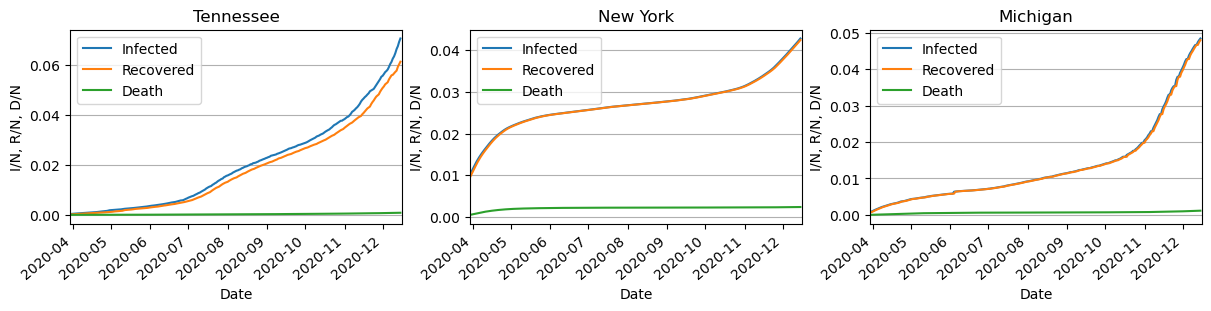

In [22]:
fig1, ax1 = plt.subplots(1, 3,constrained_layout=True,figsize=(12, 3))
ax1[0].plot(dates,II_T/N1 , label='Infected')
ax1[0].plot(dates,RR_T/N1, label='Recovered')
ax1[0].plot(dates,DD_T/N1, label='Death')
ax1[0].set_xlabel('Date')
ax1[0].set_ylabel('I/N, R/N, D/N')
ax1[0].set_title('Tennessee')
ax1[0].set_xlim(lims)
for label in ax1[0].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[0].legend()
ax1[0].grid(axis='y')

ax1[1].plot(dates,II_N/N2 , label='Infected')
ax1[1].plot(dates,RR_N/N2, label='Recovered')
ax1[1].plot(dates,DD_N/N2, label='Death')
ax1[1].set_xlabel('Date')
ax1[1].set_ylabel('I/N, R/N, D/N')
ax1[1].set_title('New York')
ax1[1].set_xlim(lims)
for label in ax1[1].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[1].legend()
ax1[1].grid(axis='y')

ax1[2].plot(dates,II_M/N3 , label='Infected')
ax1[2].plot(dates,RR_M/N3, label='Recovered')
ax1[2].plot(dates,DD_M/N3, label='Death')
ax1[2].set_xlabel('Date')
ax1[2].set_ylabel('I/N, R/N, D/N')
ax1[2].set_title('Michigan')
ax1[2].set_xlim(lims)
for label in ax1[2].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[2].legend()
ax1[2].grid(axis='y')
fig1.savefig(out+"actualdata.eps")

### Visualize Compliance Rate

In [32]:
### Tennessee
T_com_pinn =np.loadtxt("TN/PINN/Figures/compliance_predpinn_c1.txt")
T_beta_pinn =np.loadtxt("TN/PINN/Figures/beta_predpinn_c1.txt")
T_gamma_pinn =np.loadtxt("TN/PINN/Figures/gamma_predpinn_c1.txt")
T_delta_pinn =np.loadtxt("TN/PINN/Figures/delta_predpinn_c1.txt")
T_inf_pinn =np.loadtxt("TN/PINN/Figures/I_predpinn_c1.txt")

T_com_beinn =np.loadtxt("TN/PINN_B/Figures/compliance_pred_c1_0.1.txt")
T_beta_beinn =np.loadtxt("TN/PINN_B/Figures/beta_pred_c1_0.1.txt")
T_gamma_beinn =np.loadtxt("TN/PINN_B/Figures/gamma_pred_c1_0.1.txt")
T_delta_beinn =np.loadtxt("TN/PINN_B/Figures/delta_pred_c1_0.1.txt")
T_inf_beinn =np.loadtxt("TN/PINN_B/Figures/I_pred_c1_0.1.txt")

### New York
N_com_pinn =np.loadtxt("NYC/PINN/Figures/compliance_predpinn_c1.txt")
N_beta_pinn =np.loadtxt("NYC/PINN/Figures/beta_predpinn_c1.txt")
N_gamma_pinn =np.loadtxt("NYC/PINN/Figures/gamma_predpinn_c1.txt")
N_delta_pinn =np.loadtxt("NYC/PINN/Figures/delta_predpinn_c1.txt")
N_inf_pinn =np.loadtxt("NYC/PINN/Figures/I_predpinn_c1.txt")

N_com_beinn =np.loadtxt("NYC/PINN_B/Figures/compliance_pred_c1_0.09.txt")
N_beta_beinn =np.loadtxt("NYC/PINN_B/Figures/beta_pred_c1_0.09.txt")
N_gamma_beinn =np.loadtxt("NYC/PINN_B/Figures/gamma_pred_c1_0.09.txt")
N_delta_beinn =np.loadtxt("NYC/PINN_B/Figures/delta_pred_c1_0.09.txt")
N_inf_beinn =np.loadtxt("NYC/PINN_B/Figures/I_pred_c1_0.09.txt")

### Michigan
M_com_pinn =np.loadtxt("MI/PINN/Figures/compliance_predpinn_c1.txt")
M_beta_pinn =np.loadtxt("MI/PINN/Figures/beta_predpinn_c1.txt")
M_gamma_pinn =np.loadtxt("MI/PINN/Figures/gamma_predpinn_c1.txt")
M_delta_pinn =np.loadtxt("MI/PINN/Figures/delta_predpinn_c1.txt")
M_inf_pinn =np.loadtxt("MI/PINN/Figures/I_predpinn_c1.txt")

M_com_beinn =np.loadtxt("MI/PINN_B/Figures/compliance_pred_c1_0.001.txt")
M_beta_beinn =np.loadtxt("MI/PINN_B/Figures/beta_pred_c1_0.001.txt")
M_gamma_beinn =np.loadtxt("MI/PINN_B/Figures/gamma_pred_c1_0.001.txt")
M_delta_beinn =np.loadtxt("MI/PINN_B/Figures/delta_pred_c1_0.001.txt")
M_inf_beinn =np.loadtxt("MI/PINN_B/Figures/I_pred_c1_0.001.txt")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


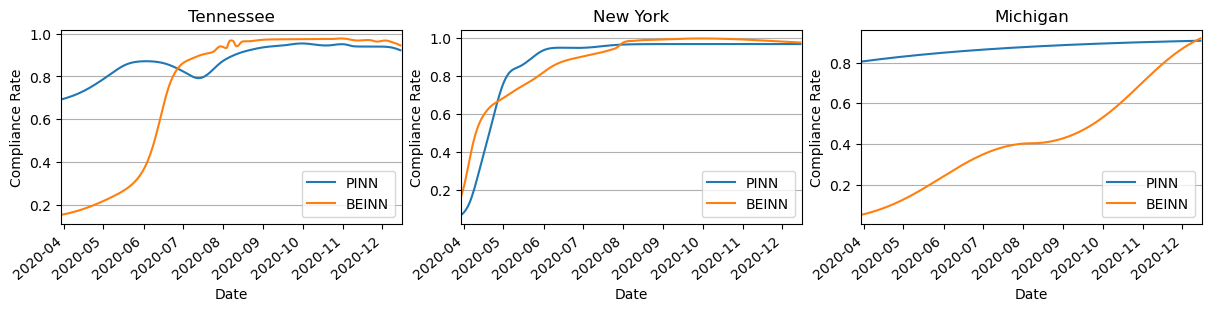

In [34]:
fig2, ax1 = plt.subplots(1, 3,constrained_layout=True,figsize=(12, 3))
ax1[0].plot(dates,T_com_pinn , label='PINN')
ax1[0].plot(dates,T_com_beinn, label='BEINN')
ax1[0].set_xlabel('Date')
ax1[0].set_ylabel('Compliance Rate')
ax1[0].set_title('Tennessee')
ax1[0].set_xlim(lims)
for label in ax1[0].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[0].legend()
ax1[0].grid(axis='y')

ax1[1].plot(dates,N_com_pinn , label='PINN')
ax1[1].plot(dates,N_com_beinn, label='BEINN')
ax1[1].set_xlabel('Date')
ax1[1].set_ylabel('Compliance Rate')
ax1[1].set_title('New York')
ax1[1].set_xlim(lims)
for label in ax1[1].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[1].legend()
ax1[1].grid(axis='y')

ax1[2].plot(dates,M_com_pinn , label='PINN')
ax1[2].plot(dates,M_com_beinn, label='BEINN')
ax1[2].set_xlabel('Date')
ax1[2].set_ylabel('Compliance Rate')
ax1[2].set_title('Michigan')
ax1[2].set_xlim(lims)
for label in ax1[2].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[2].legend()
ax1[2].grid(axis='y')
fig2.savefig(out+"comply.eps")

### Effects of Compliance

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


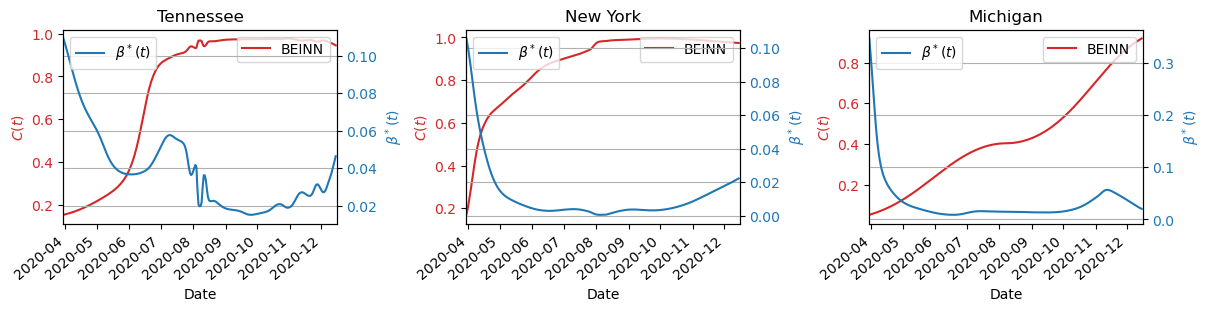

In [39]:
## Tennessee
fig3, ax1 = plt.subplots(1, 3,constrained_layout=True,figsize=(12, 3))
color = 'tab:red'
ax1[0].set_xlabel('Date')
ax1[0].set_ylabel(r'$C(t)$', color=color)
ax1[0].set_title('Tennessee')
ax1[0].plot(dates, T_com_beinn, color=color)
ax1[0].tick_params(axis='y', labelcolor=color)
ax1[0].legend(['BEINN'], loc='upper right')
# lims = (np.datetime64('2020-03-30'), np.datetime64('2020-08-04'))
ax1[0].set_xlim(lims)
for label in ax1[0].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax2 = ax1[0].twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel(r'$\beta^*(t)$', color=color)  # we already handled the x-label with ax1
ax2.plot(dates,T_beta_beinn*(1.0-T_com_beinn), color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend([r'$\beta^*(t)$'], loc='upper left')
ax2.grid(axis='y')

color = 'tab:red'
ax1[1].set_xlabel('Date')
ax1[1].set_ylabel(r'$C(t)$', color=color)
ax1[1].set_title('New York')
ax1[1].plot(dates, N_com_beinn, color=color)
ax1[1].tick_params(axis='y', labelcolor=color)
ax1[1].legend(['BEINN'], loc='upper right')
# lims = (np.datetime64('2020-03-30'), np.datetime64('2020-08-04'))
ax1[1].set_xlim(lims)
for label in ax1[1].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax2 = ax1[1].twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel(r'$\beta^*(t)$', color=color)  # we already handled the x-label with ax1
ax2.plot(dates,N_beta_beinn*(1.0-N_com_beinn), color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend([r'$\beta^*(t)$'], loc='upper left')
ax2.grid(axis='y')

color = 'tab:red'
ax1[2].set_xlabel('Date')
ax1[2].set_ylabel(r'$C(t)$', color=color)
ax1[2].set_title('Michigan')
ax1[2].plot(dates, M_com_beinn, color=color)
ax1[2].tick_params(axis='y', labelcolor=color)
ax1[2].legend(['BEINN'], loc='upper right')
# lims = (np.datetime64('2020-03-30'), np.datetime64('2020-08-04'))
ax1[2].set_xlim(lims)
for label in ax1[2].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax2 = ax1[2].twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel(r'$\beta^*(t)$', color=color)  # we already handled the x-label with ax1
ax2.plot(dates,M_beta_beinn*(1.0-M_com_beinn), color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend([r'$\beta^*(t)$'], loc='upper left')
ax2.grid(axis='y')
fig3.savefig(out+"effectOnBeta.eps")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


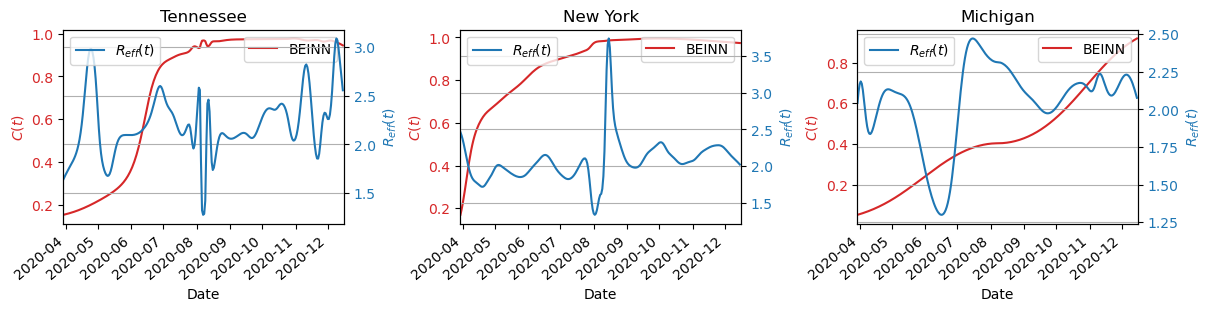

In [40]:
## Tennessee
fig4, ax1 = plt.subplots(1, 3,constrained_layout=True,figsize=(12, 3))
color = 'tab:red'
ax1[0].set_xlabel('Date')
ax1[0].set_ylabel(r'$C(t)$', color=color)
ax1[0].set_title('Tennessee')
ax1[0].plot(dates, T_com_beinn, color=color)
ax1[0].tick_params(axis='y', labelcolor=color)
ax1[0].legend(['BEINN'], loc='upper right')
# lims = (np.datetime64('2020-03-30'), np.datetime64('2020-08-04'))
ax1[0].set_xlim(lims)
for label in ax1[0].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax2 = ax1[0].twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel(r'$R_{eff}(t)$', color=color)  # we already handled the x-label with ax1
ax2.plot(dates,T_beta_beinn*(1.0-T_com_beinn)/(T_gamma_beinn+T_delta_beinn), color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend([r'$R_{eff}(t)$'], loc='upper left')
ax2.grid(axis='y')

color = 'tab:red'
ax1[1].set_xlabel('Date')
ax1[1].set_ylabel(r'$C(t)$', color=color)
ax1[1].set_title('New York')
ax1[1].plot(dates, N_com_beinn, color=color)
ax1[1].tick_params(axis='y', labelcolor=color)
ax1[1].legend(['BEINN'], loc='upper right')
# lims = (np.datetime64('2020-03-30'), np.datetime64('2020-08-04'))
ax1[1].set_xlim(lims)
for label in ax1[1].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax2 = ax1[1].twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel(r'$R_{eff}(t)$', color=color)  # we already handled the x-label with ax1
ax2.plot(dates,N_beta_beinn*(1.0-N_com_beinn)/(N_gamma_beinn+N_delta_beinn), color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend([r'$R_{eff}(t)$'], loc='upper left')
ax2.grid(axis='y')

color = 'tab:red'
ax1[2].set_xlabel('Date')
ax1[2].set_ylabel(r'$C(t)$', color=color)
ax1[2].set_title('Michigan')
ax1[2].plot(dates, M_com_beinn, color=color)
ax1[2].tick_params(axis='y', labelcolor=color)
ax1[2].legend(['BEINN'], loc='upper right')
# lims = (np.datetime64('2020-03-30'), np.datetime64('2020-08-04'))
ax1[2].set_xlim(lims)
for label in ax1[2].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax2 = ax1[2].twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel(r'$R_{eff}(t)$', color=color)  # we already handled the x-label with ax1
ax2.plot(dates,M_beta_beinn*(1.0-M_com_beinn)/(M_gamma_beinn+M_delta_beinn), color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend([r'$R_{eff}(t)$'], loc='upper left')
ax2.grid(axis='y')
fig4.savefig(out+"effectOnReff.eps")
plt.show()

## Data Fitting

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


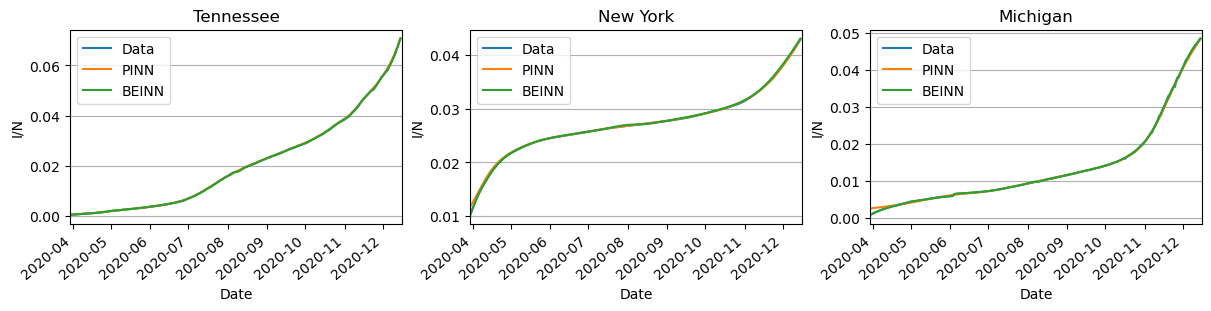

In [44]:
fig5, ax1 = plt.subplots(1, 3,constrained_layout=True,figsize=(12, 3))
ax1[0].plot(dates,II_T/N1 , label='Data')
ax1[0].plot(dates,T_inf_pinn, label='PINN')
ax1[0].plot(dates,T_inf_beinn, label='BEINN')
ax1[0].set_xlabel('Date')
ax1[0].set_ylabel('I/N')
ax1[0].set_title('Tennessee')
ax1[0].set_xlim(lims)
for label in ax1[0].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[0].legend()
ax1[0].grid(axis='y')

ax1[1].plot(dates,II_N/N2 , label='Data')
ax1[1].plot(dates,N_inf_pinn, label='PINN')
ax1[1].plot(dates,N_inf_beinn, label='BEINN')
ax1[1].set_xlabel('Date')
ax1[1].set_ylabel('I/N')
ax1[1].set_title('New York')
ax1[1].set_xlim(lims)
for label in ax1[1].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[1].legend()
ax1[1].grid(axis='y')

ax1[2].plot(dates,II_M/N3 ,label='Data')
ax1[2].plot(dates,M_inf_pinn, label='PINN')
ax1[2].plot(dates,M_inf_beinn, label='BEINN')
ax1[2].set_xlabel('Date')
ax1[2].set_ylabel('I/N')
ax1[2].set_title('Michigan')
ax1[2].set_xlim(lims)
for label in ax1[2].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[2].legend()
ax1[2].grid(axis='y')
fig5.savefig(out+"datafitting.eps")

## computational Analysis

In [ ]:
#cpu time

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


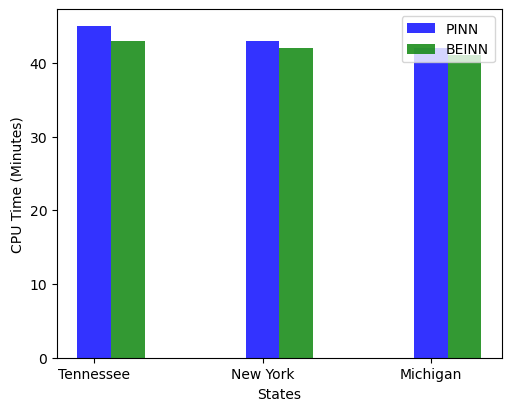

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


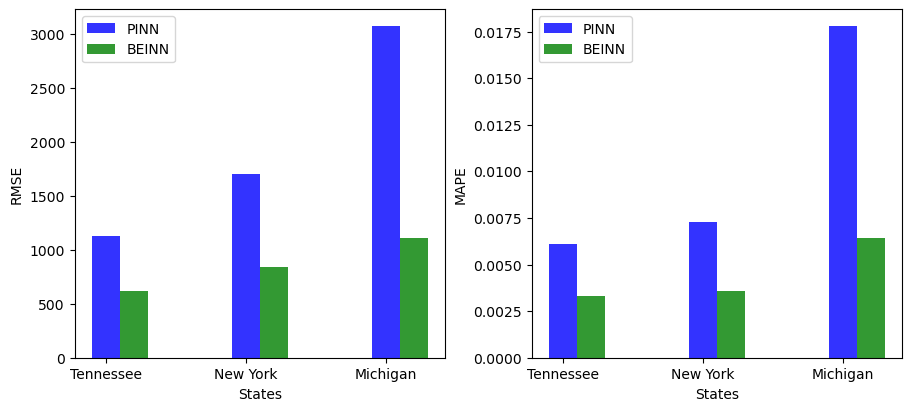

In [47]:
states = ['Tennessee', 'New York', 'Michigan']
# Set bar width
bar_width = 0.2
# Create the figure and axes objects
fig6, ax1 = plt.subplots(constrained_layout=True,figsize=(5, 4))
# Set the x-axis tick locations and labels
ax1.set_xticks(np.arange(len(states)))
ax1.set_xticklabels(states)
# Set the y-axis label
ax1.set_ylabel('CPU Time (Minutes)')
ax1.set_xlabel('States')
# Set the chart title
# ax1.set_title('Comparison of RMSE values for different layers and neurons')
# Set the opacity of the bars
opacity = 0.8
# Plot the paired RMSE values
rects1 = ax1.bar(np.arange(len(states)), [45, 43, 42], bar_width, alpha=opacity, color='b', label='PINN')
rects2 = ax1.bar(np.arange(len(states)) + bar_width, [43, 42, 41], bar_width, alpha=opacity, color='g', label='BEINN')
ax1.legend()
fig6.savefig(out+'cputimeComp.eps')
plt.show()


states = ['Tennessee', 'New York', 'Michigan']
# Set bar width
bar_width = 0.2
# Create the figure and axes objects
fig7, ax1 = plt.subplots(1, 2,constrained_layout=True,figsize=(9, 4))
# Set the x-axis tick locations and labels
ax1[0].set_xticks(np.arange(len(states)))
ax1[0].set_xticklabels(states)
# Set the y-axis label
ax1[0].set_ylabel('RMSE')
ax1[0].set_xlabel('States')
# Set the chart title
# ax1.set_title('Comparison of RMSE values for different layers and neurons')
# Set the opacity of the bars
opacity = 0.8
# Plot the paired RMSE values
rects1 = ax1[0].bar(np.arange(len(states)), [1129, 1699, 3071], bar_width, alpha=opacity, color='b', label='PINN')
rects2 = ax1[0].bar(np.arange(len(states)) + bar_width, [616, 836, 1108], bar_width, alpha=opacity, color='g', label='BEINN')
ax1[0].legend()

# Set the x-axis tick locations and labels
ax1[1].set_xticks(np.arange(len(states)))
ax1[1].set_xticklabels(states)
# Set the y-axis label
ax1[1].set_ylabel('MAPE')
ax1[1].set_xlabel('States')
# Set the chart title
# ax1.set_title('Comparison of RMSE values for different layers and neurons')
# Set the opacity of the bars
opacity = 0.8
# Plot the paired RMSE values
rects1 = ax1[1].bar(np.arange(len(states)), [0.0061, 0.0073, 0.0178], bar_width, alpha=opacity, color='b', label='PINN')
rects2 = ax1[1].bar(np.arange(len(states)) + bar_width, [0.0033, 0.0036, 0.0064], bar_width, alpha=opacity, color='g', label='BEINN')
ax1[1].legend()
fig7.savefig(out+'rmse_mape.eps')
plt.show()




## Load Data

`Two cases: case 1 and case 2. Uncomment case 1 to run case 2`

### BEINN

In [2]:
# Load data for case 1
S_original = np.loadtxt("PINN_B/Figures/S_true_c1_0.1.txt").reshape(-1, 1)
I_original = np.loadtxt("PINN_B/Figures/I_true_c1_0.1.txt").reshape(-1, 1)
R_original = np.loadtxt("PINN_B/Figures/R_true_c1_0.1.txt").reshape(-1, 1)
D_original = np.loadtxt("PINN_B/Figures/D_true_c1_0.1.txt").reshape(-1, 1)

# Load predicted data for case 1
S_pred = np.loadtxt("PINN_B/Figures/S_pred_c1_0.1.txt")
I_pred = np.loadtxt("PINN_B/Figures/I_pred_c1_0.1.txt")
R_pred = np.loadtxt("PINN_B/Figures/R_pred_c1_0.1.txt")
D_pred = np.loadtxt("PINN_B/Figures/D_pred_c1_0.1.txt")

# Load predicted parameters for case 1
beta_pred = np.loadtxt("PINN_B/Figures/beta_pred_c1_0.1.txt")
gamma_pred = np.loadtxt("PINN_B/Figures/gamma_pred_c1_0.1.txt")
delta_pred = np.loadtxt("PINN_B/Figures/delta_pred_c1_0.1.txt")
compliance_pred = np.loadtxt("PINN_B/Figures/compliance_pred_c1_0.1.txt")

# Load loss data for case 1
total_loss = np.loadtxt("PINN_B/Figures/total_loss_c1_0.1.txt")
data_loss = np.loadtxt("PINN_B/Figures/lossData_c1_0.1.txt")
resid_loss = np.loadtxt("PINN_B/Figures/lossPhy_c1_0.1.txt")

# Load epochs data
epochs = np.arange(len(total_loss))

N0 = 6.82*1.e6
I_or =I_original.reshape(-1,)
I_p  =I_pred
test_actual=I_or*N0
test_pred =I_p*N0
rmse =np.sqrt(mean_squared_error(test_actual, test_pred))
mape =np.linalg.norm((test_pred-test_actual),2)/np.linalg.norm(test_actual, 2)
ev =1- (np.var(test_pred-test_actual)/np.var(test_actual))
rel =np.sum((test_actual-test_pred)**2/(test_actual**2))

print('RMSE',rmse)
print('MAPE',mape)
print('EV', ev)
print('REL', rel)

# ## Load data for case 2
# S_original = np.loadtxt("Figures/S_true_c2.txt").reshape(-1,1)
# I_original = np.loadtxt("Figures/I_true_c2.txt").reshape(-1,1)
# R_original = np.loadtxt("Figures/R_true_c2.txt").reshape(-1,1)
# D_original = np.loadtxt("Figures/D_true_c2.txt").reshape(-1,1)

# ## Load predicted data for case 2
# S_pred = np.loadtxt("Figures/S_pred_c2.txt")
# I_pred = np.loadtxt("Figures/I_pred_c2.txt")
# R_pred = np.loadtxt("Figures/R_pred_c2.txt")
# D_pred = np.loadtxt("Figures/D_pred_c2.txt")

# ## Load predicted parameters for case 2
# beta_pred = np.loadtxt("Figures/beta_pred_c2.txt")
# gamma_pred = np.loadtxt("Figures/gamma_pred_c2.txt")
# delta_pred = np.loadtxt("Figures/delta_pred_c2.txt")
# compliance_pred = np.loadtxt("Figures/compliance_pred_c2.txt")

# ## Load loss data for case 2
# total_loss = np.loadtxt("Figures/total_loss_c2.txt")
# data_loss = np.loadtxt("Figures/lossData_c2.txt")
# resid_loss = np.loadtxt("Figures/lossPhy_c2.txt")

# ## Load epochs data
# epochs = np.arange(len(total_loss))


RMSE 851.1509028403239
MAPE 0.004573622726139002
EV 0.9999731822102003
REL 0.04758602519958143


### PINN results

In [3]:
# Load predicted data for case 1
S_pred1 = np.loadtxt("PINN/Figures/S_predpinn_c1.txt")
I_pred1 = np.loadtxt("PINN/Figures/I_predpinn_c1.txt")
R_pred1 = np.loadtxt("PINN/Figures/R_predpinn_c1.txt")
D_pred1 = np.loadtxt("PINN/Figures/D_predpinn_c1.txt")

# Load predicted parameters for case 1
beta_pred1 = np.loadtxt("PINN/Figures/beta_predpinn_c1.txt")
gamma_pred1 = np.loadtxt("PINN/Figures/gamma_predpinn_c1.txt")
delta_pred1 = np.loadtxt("PINN/Figures/delta_predpinn_c1.txt")
compliance_pred1 = np.loadtxt("PINN/Figures/compliance_predpinn_c1.txt")

# Load loss data for case 1
total_loss1 = np.loadtxt("PINN/Figures/total_losspinn_c1.txt")
data_loss1 = np.loadtxt("PINN/Figures/lossDatapinn_c1.txt")
resid_loss1 = np.loadtxt("PINN/Figures/lossPhypinn_c1.txt")

In [4]:
N0 = 6.82*1.e6
I_or =I_original.reshape(-1,)
I_p  =I_pred1
test_actual=I_or*N0
test_pred =I_p*N0
rmse =np.sqrt(mean_squared_error(test_actual, test_pred))
mape =np.linalg.norm((test_pred-test_actual),2)/np.linalg.norm(test_actual, 2)
ev =1- (np.var(test_pred-test_actual)/np.var(test_actual))
rel =np.sum((test_actual-test_pred)**2/(test_actual**2))

print('RMSE',rmse)
print('MAPE',mape)
print('EV', ev)
print('REL', rel)

RMSE 1033.3469301272605
MAPE 0.005552645233465299
EV 0.9999597978997581
REL 0.03765547307490906


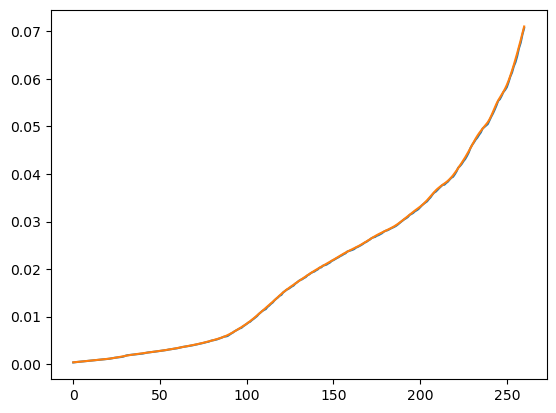

In [5]:
plt.plot(I_original)
plt.plot(I_p)

## RK4 method

In [6]:
import numpy as np

def rk4_system(f, t, y, h, args):
    """
    4th order Runge-Kutta method for solving differential equations
    f: callable, function to be solved
    t: float, current time
    y: numpy array, current state of the system
    h: float, step size
    args: tuple, additional arguments to pass to f
    """
    k1 = h*f(t, y, *args)
    k2 = h*f(t + 0.5*h, y + 0.5*k1, *args)
    k3 = h*f(t + 0.5*h, y + 0.5*k2, *args)
    k4 = h*f(t + h, y + k3, *args)
    return y + (k1 + 2*k2 + 2*k3 + k4)/6

def sird_ode(t, y, beta, gamma, delta, B):
    """
    SIRD ODE model
    t: float, current time
    y: numpy array, current state of the system
    beta: float, rate of infection
    gamma: float, rate of recovery
    delta: float, rate of mortality
    B: float, fraction of population taking precautions
    """
    S, I, R, D = y
    N = 1.0
    dSdt = -beta*(1.0-B)*S*I/N
    dIdt = beta*(1.0-B)*S*I/N - gamma*I - delta*I
    dRdt = gamma*I
    dDdt = delta*I
    return np.array([dSdt, dIdt, dRdt, dDdt])

def solve_sird_model(sb, sg, sd, ct, y0, Y):
    """
    Solves the SIRD model using the RK4 method
    sb: numpy array, values of beta over time
    sg: numpy array, values of gamma over time
    sd: numpy array, values of delta over time
    ct: numpy array, values of B over time
    y0: list, initial values of S, I, R, and D
    Y: numpy array, data to fit the model to
    """
    t_max = len(sb)
    dt = 1.0
    num_steps = int(t_max/dt)
    t = np.linspace(0, t_max, num_steps)
    y = np.zeros((num_steps, len(y0)))
    beta = sb
    gamma = sg
    delta = sd
    B = ct
    y[0, :] = y0
    for i in range(num_steps-1):
        y[i+1, :] = rk4_system(sird_ode, t[i], y[i, :], dt, (beta[i], gamma[i], delta[i], B[i]))
    return y

# Initial values
S1, I1, R1, D1 = S_original, I_original, R_original, D_original
y0 = [S1[0, 0], I1[0, 0], R1[0, 0], D1[0, 0]]


In [7]:
Y =np.hstack((S1, I1, R1, D1))

rk4_y =solve_sird_model(beta_pred, gamma_pred, delta_pred, compliance_pred, y0, Y)
rks, rki, rkr, rkd=rk4_y[:,0:1], rk4_y[:,1:2], rk4_y[:,2:3], rk4_y[:,3:4]

## Data-Driven Simulations

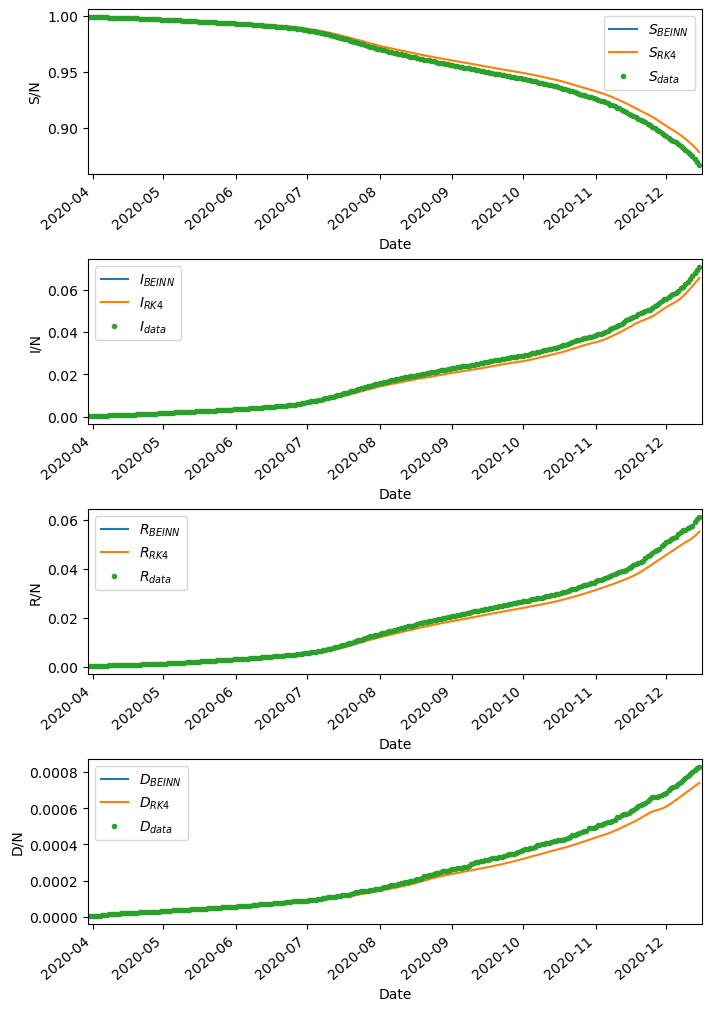

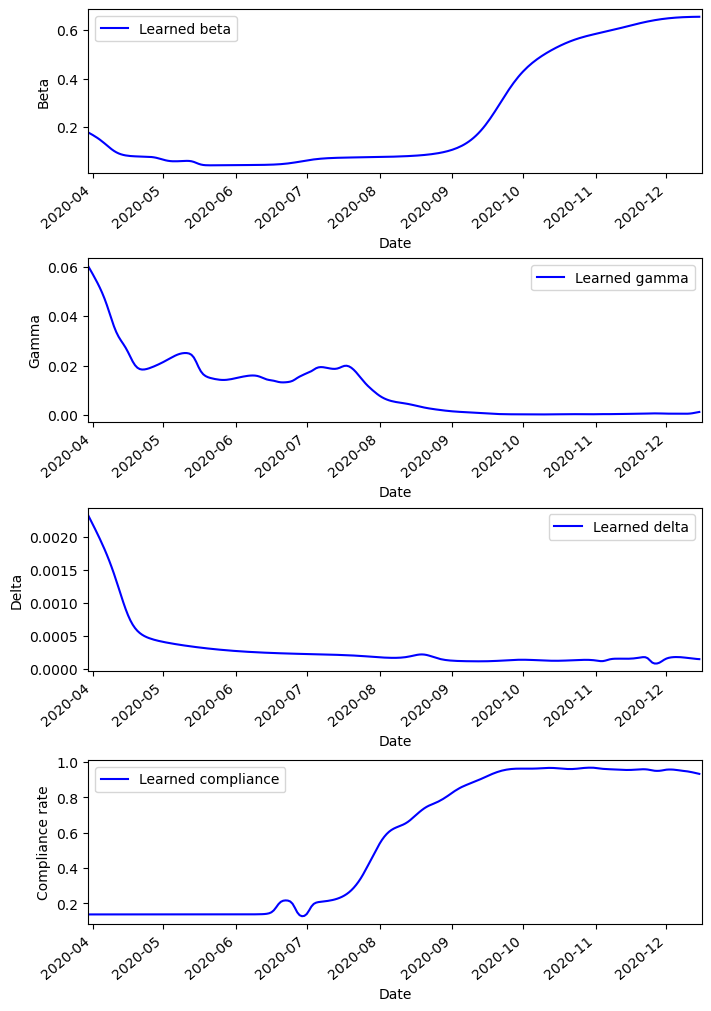

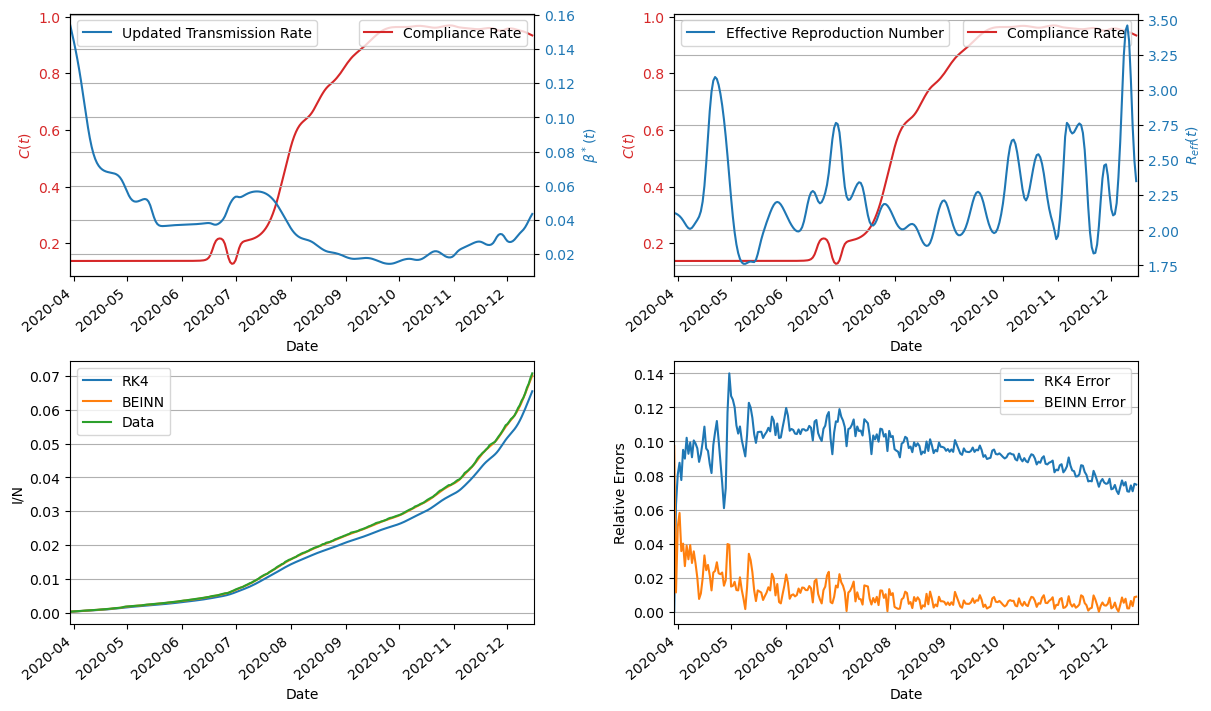

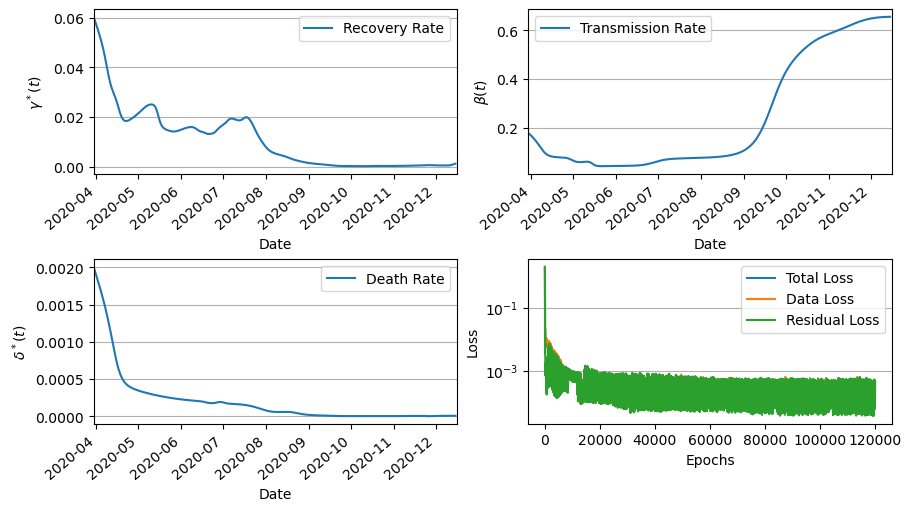

In [8]:
#case 1: 
st ='2020-03-30'
ed ='2020-12-16'
#case 2: 
# st ='2020-12-17'
# ed ='2021-05-16'


#change the from c1 to c2
case ='c1'
date_begin = dt.date(2020, 3, 30) #change from 2020, 12, 17 for Case 2
date_end = date_begin + dt.timedelta(days=261) #change to 150 for case 2
delt = dt.timedelta(days=1)
dates = mpl.dates.drange(date_begin, date_end, delt)
lims = (np.datetime64(st), np.datetime64(ed))

rk_err = np.abs(rki - I1)/(I1)
beinn_err = np.abs(I_pred.reshape(-1,1) - I1)/(I1)
fig1, axs = plt.subplots(4, 1, constrained_layout=True, figsize=(7, 10))
y = np.array([S_pred,I_pred,R_pred, D_pred]) ## BEINN
y1 = np.array([S1, I1, R1, D1])
y2 = np.array([rks,rki,rkr, rkd])
y_label = ["S/N","I/N","R/N", "D/N"]
legend = [(r'$S_{BEINN}$',r'$S_{RK4}$',r'$S_{data}$'),(r'$I_{BEINN}$',r'$I_{RK4}$',r'$I_{data}$'),
        (r'$R_{BEINN}$',r'$R_{RK4}$',r'$R_{data}$'), (r'$D_{BEINN}$',r'$D_{RK4}$',r'$D_{data}$')]
for nn, ax in enumerate(axs):
    ax.plot(dates, y[nn])
    ax.plot(dates, y2[nn])
    ax.plot(dates, y1[nn],'.')
    ax.set_xlabel("Date")
    ax.set_ylabel(y_label[nn])
    ax.set_xlim(lims)
    ax.legend(legend[nn])
    # rotate_labels...
    for label in ax.get_xticklabels():
        label.set_rotation(40)
        label.set_horizontalalignment('right')
#axs[0].set_title('Comparision')
fig1.savefig(out+"sol_{}.pdf".format(case))
plt.show()

fig2, axs = plt.subplots(4, 1, constrained_layout=True, figsize=(7, 10))
axs[0].plot(dates, beta_pred, label='Learned beta', color='blue')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Beta')
axs[0].set_xlim(lims)
for label in axs[0].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
axs[0].legend()

axs[1].plot(dates, gamma_pred*(1.0-compliance_pred), label='Learned gamma', color='blue')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Gamma')
axs[1].set_xlim(lims)
for label in axs[1].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
axs[1].legend()

axs[2].plot(dates, delta_pred, label='Learned delta', color='blue')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Delta')
axs[2].set_xlim(lims)
for label in axs[2].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
axs[2].legend()

axs[3].plot(dates, compliance_pred, label='Learned compliance', color='blue')
axs[3].set_xlabel('Date')
axs[3].set_ylabel('Compliance rate')
axs[3].set_xlim(lims)
for label in axs[3].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
axs[3].legend()
fig2.savefig(out+"param_{}.pdf".format(case))
plt.show()

fig1b, ax1 = plt.subplots(2, 2,constrained_layout=True,figsize=(12, 7))
# fig1.suptitle('{}'.format(name), fontsize=16)
color = 'tab:red'
ax1[0, 0].set_xlabel('Date')
ax1[0, 0].set_ylabel(r'$C(t)$', color=color)
ax1[0, 0].plot(dates, compliance_pred, color=color)
ax1[0, 0].tick_params(axis='y', labelcolor=color)
ax1[0, 0].legend(['Compliance Rate'], loc='upper right')
# lims = (np.datetime64('2020-03-30'), np.datetime64('2020-08-04'))
ax1[0, 0].set_xlim(lims)
for label in ax1[0, 0].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax2 = ax1[0, 0].twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel(r'$\beta^*(t)$', color=color)  # we already handled the x-label with ax1
ax2.plot(dates,beta_pred*(1.0-compliance_pred), color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['Updated Transmission Rate'], loc='upper left')
ax2.grid(axis='y')

color = 'tab:red'
ax1[0,1].set_xlabel('Date')
ax1[0,1].set_ylabel(r'$C(t)$', color=color)
ax1[0,1].plot(dates, compliance_pred, color=color)
ax1[0,1].tick_params(axis='y', labelcolor=color)
ax1[0,1].legend(['Compliance Rate'], loc='upper right')
ax1[0,1].set_xlim(lims)
for label in ax1[0,1].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax2 = ax1[0,1].twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel(r'$R_{eff}(t)$', color=color)  # we already handled the x-label with ax1
ax2.plot(dates,beta_pred*(1.0-compliance_pred)/(gamma_pred+delta_pred), color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['Effective Reproduction Number'], loc='upper left')
ax2.grid(axis='y')

ax1[1,0].plot(dates, rki, label='RK4')
ax1[1, 0].plot(dates, I_pred, label='BEINN')
ax1[1, 0].plot(dates, I1, label='Data')
ax1[1, 0].set_xlabel('Date')
ax1[1, 0].set_ylabel('I/N')
ax1[1, 0].set_xlim(lims)
for label in ax1[1, 0].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[1, 0].legend()
ax1[1, 0].grid(axis='y')

ax1[1, 1].plot(dates, rk_err, label='RK4 Error')
ax1[1, 1].plot(dates, beinn_err, label='BEINN Error')
ax1[1, 1].set_xlabel('Date')
ax1[1, 1].set_ylabel('Relative Errors')
ax1[1, 1].set_xlim(lims)
for label in ax1[1, 1].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[1, 1].legend()
ax1[1, 1].grid(axis='y')
# fig1a.savefig(out+"reff_{}.pdf".format(case))
# fig.savefig("ana1_{}_{}.pdf".format(option, case))
fig1b.savefig(out+"beta_reff_{}.pdf".format(case))
plt.show()




fig1A, ax1 = plt.subplots(2, 2,constrained_layout=True,figsize=(9, 5))
ax1[0,0].plot(dates, gamma_pred*(1.0-compliance_pred), label='Recovery Rate')
ax1[0,0].set_xlabel('Date')
ax1[0,0].set_ylabel(r'$\gamma^*(t)$')
ax1[0,0].set_xlim(lims)
# ax1[0].set_ylim([-0.1,0.5])
for label in ax1[0,0].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[0,0].legend()
ax1[0,0].grid(axis='y')

ax1[1,0].plot(dates, delta_pred*(1.0-compliance_pred), label='Death Rate')
ax1[1,0].set_xlabel('Date')
ax1[1,0].set_ylabel(r'$\delta^*(t)$')
ax1[1,0].set_xlim(lims)
# ax1[0].set_ylim([-0.1,0.5])
for label in ax1[1,0].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[1,0].legend()
ax1[1,0].grid(axis='y')

ax1[0,1].plot(dates, beta_pred, label='Transmission Rate')
ax1[0,1].set_xlabel('Date')
ax1[0,1].set_ylabel(r'$\beta(t)$')
ax1[0,1].set_xlim(lims)
# ax1[0].set_ylim([-0.1,0.5])
for label in ax1[0,1].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[0,1].legend()
ax1[0,1].grid(axis='y')


ax1[1,1].semilogy(epochs, total_loss, label='Total Loss')
ax1[1, 1].semilogy(epochs, data_loss, label='Data Loss')
ax1[1, 1].semilogy(epochs, resid_loss, label='Residual Loss')
ax1[1, 1].set_xlabel('Epochs')
ax1[1, 1].set_ylabel('Loss')
# ax1[1].set_xlim(lims)
# for label in ax1[1].get_xticklabels():
#     label.set_rotation(40)
#     label.set_horizontalalignment('right')
ax1[1, 1].legend()
ax1[1, 1].grid(axis='y')
# fig1a.savefig(out+"reff_{}.pdf".format(case))
# fig.savefig("ana1_{}_{}.pdf".format(option, case))
fig1A.savefig(out+"ep_loss_{}.pdf".format(case))
plt.show()





## Epidemiology Parameters

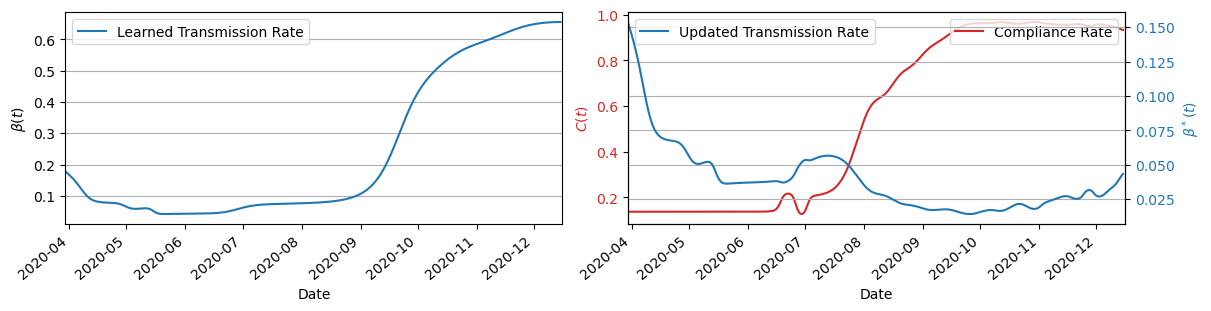

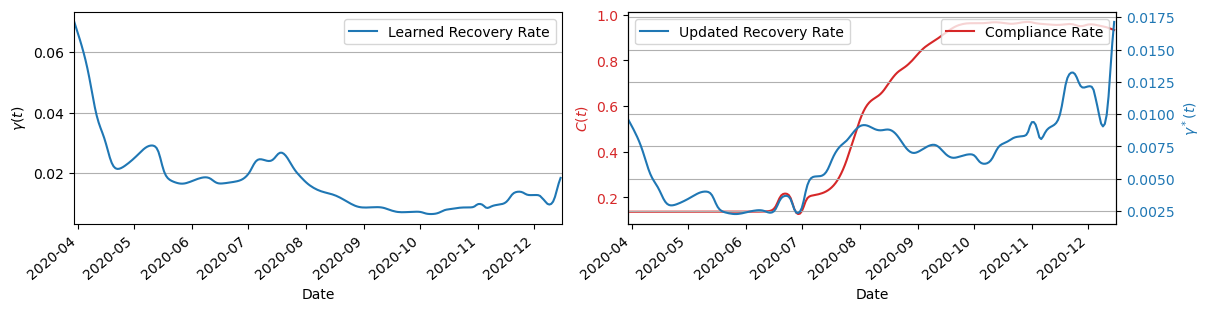

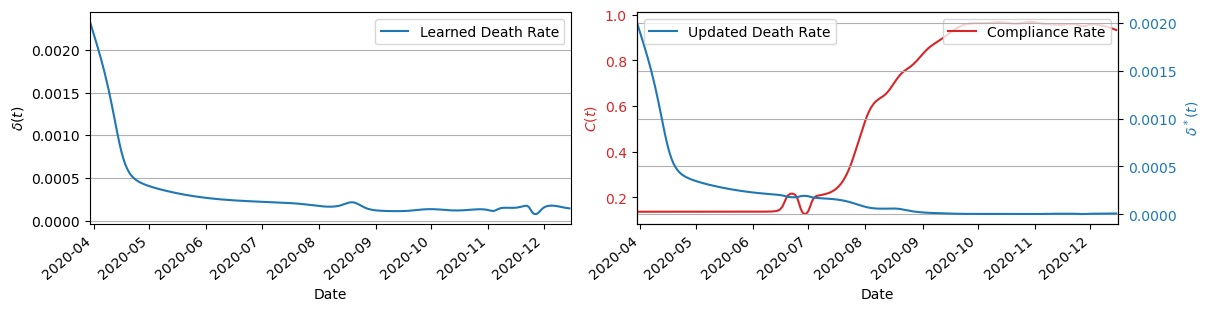

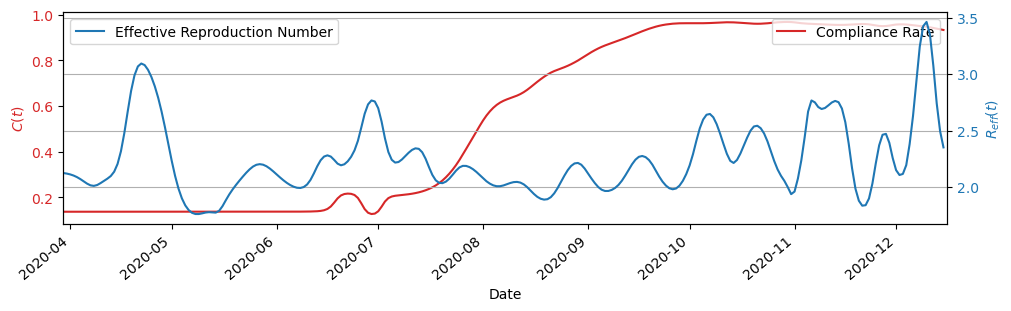

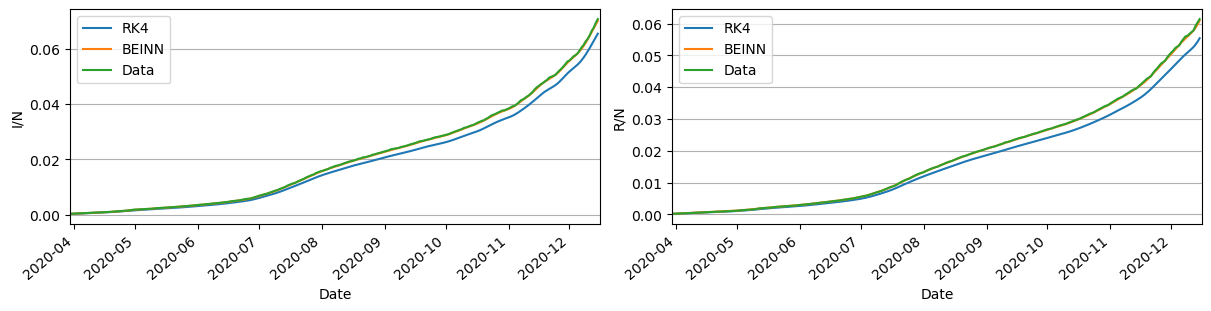

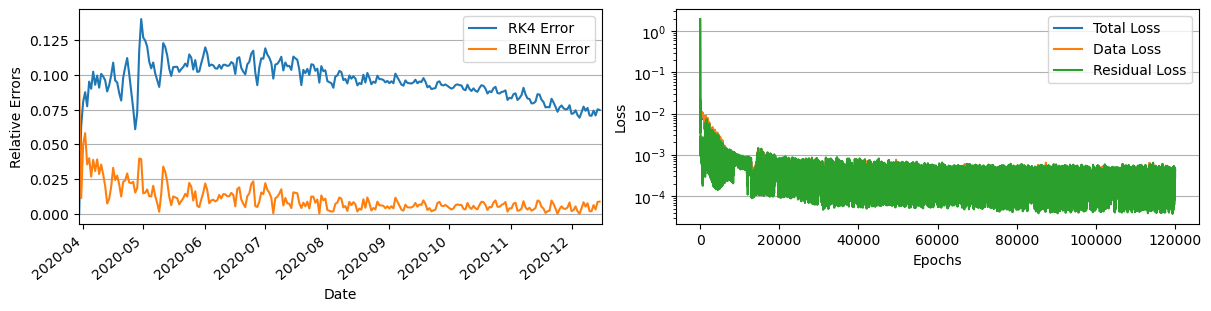

In [9]:
fig1b1, ax1 = plt.subplots(1, 2,constrained_layout=True,figsize=(12, 3))
ax1[0].plot(dates, beta_pred, label='Learned Transmission Rate')
ax1[0].set_xlabel('Date')
ax1[0].set_ylabel(r'$\beta(t)$')
ax1[0].set_xlim(lims)
# ax1[0].set_ylim([-0.1,0.5])
for label in ax1[0].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[0].legend()
ax1[0].grid(axis='y')

color = 'tab:red'
ax1[1].set_xlabel('Date')
ax1[1].set_ylabel(r'$C(t)$', color=color)
ax1[1].plot(dates, compliance_pred, color=color)
ax1[1].tick_params(axis='y', labelcolor=color)
ax1[1].legend(['Compliance Rate'], loc='upper right')
# lims = (np.datetime64('2020-03-30'), np.datetime64('2020-08-04'))
ax1[1].set_xlim(lims)
for label in ax1[1].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax2 = ax1[1].twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel(r'$\beta^*(t)$', color=color)  # we already handled the x-label with ax1
ax2.plot(dates,beta_pred*(1.0-compliance_pred), color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['Updated Transmission Rate'], loc='upper left')
ax2.grid(axis='y')
fig1b1.savefig(out+"beta1_{}.pdf".format(case))
plt.show()


fig1b2, ax1 = plt.subplots(1, 2,constrained_layout=True,figsize=(12, 3))
ax1[0].plot(dates, gamma_pred, label='Learned Recovery Rate')
ax1[0].set_xlabel('Date')
ax1[0].set_ylabel(r'$\gamma(t)$')
ax1[0].set_xlim(lims)
# ax1[0].set_ylim([-0.1,0.5])
for label in ax1[0].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[0].legend()
ax1[0].grid(axis='y')

color = 'tab:red'
ax1[1].set_xlabel('Date')
ax1[1].set_ylabel(r'$C(t)$', color=color)
ax1[1].plot(dates, compliance_pred, color=color)
ax1[1].tick_params(axis='y', labelcolor=color)
ax1[1].legend(['Compliance Rate'], loc='upper right')
# lims = (np.datetime64('2020-03-30'), np.datetime64('2020-08-04'))
ax1[1].set_xlim(lims)
for label in ax1[1].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax2 = ax1[1].twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel(r'$\gamma^*(t)$', color=color)  # we already handled the x-label with ax1
ax2.plot(dates,gamma_pred*(compliance_pred), color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['Updated Recovery Rate'], loc='upper left')
ax2.grid(axis='y')
fig1b2.savefig(out+"gamma1_{}.pdf".format(case))
plt.show()



fig1b3, ax1 = plt.subplots(1, 2,constrained_layout=True,figsize=(12, 3))
ax1[0].plot(dates, delta_pred, label='Learned Death Rate')
ax1[0].set_xlabel('Date')
ax1[0].set_ylabel(r'$\delta(t)$')
ax1[0].set_xlim(lims)
# ax1[0].set_ylim([-0.1,0.5])
for label in ax1[0].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[0].legend()
ax1[0].grid(axis='y')

color = 'tab:red'
ax1[1].set_xlabel('Date')
ax1[1].set_ylabel(r'$C(t)$', color=color)
ax1[1].plot(dates, compliance_pred, color=color)
ax1[1].tick_params(axis='y', labelcolor=color)
ax1[1].legend(['Compliance Rate'], loc='upper right')
# lims = (np.datetime64('2020-03-30'), np.datetime64('2020-08-04'))
ax1[1].set_xlim(lims)
for label in ax1[1].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax2 = ax1[1].twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel(r'$\delta^*(t)$', color=color)  # we already handled the x-label with ax1
ax2.plot(dates,delta_pred*(1.0-compliance_pred), color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['Updated Death Rate'], loc='upper left')
ax2.grid(axis='y')
fig1b3.savefig(out+"delta1_{}.pdf".format(case))
plt.show()


fig1b4, ax1 = plt.subplots(constrained_layout=True,figsize=(10, 3))
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel(r'$C(t)$', color=color)
ax1.plot(dates, compliance_pred, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(['Compliance Rate'], loc='upper right')
ax1.set_xlim(lims)
for label in ax1.get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel(r'$R_{eff}(t)$', color=color)  # we already handled the x-label with ax1
ax2.plot(dates,beta_pred*(1.0-compliance_pred)/(gamma_pred+delta_pred), color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['Effective Reproduction Number'], loc='upper left')
ax2.grid(axis='y')
fig1b4.savefig(out+"r_eff1_{}.pdf".format(case))
plt.show()

fig1b5, ax1 = plt.subplots(1, 2,constrained_layout=True,figsize=(12, 3))
ax1[0].plot(dates, rki, label='RK4')
ax1[0].plot(dates, I_pred, label='BEINN')
ax1[0].plot(dates, I1, label='Data')
ax1[0].set_xlabel('Date')
ax1[0].set_ylabel('I/N')
ax1[0].set_xlim(lims)
for label in ax1[0].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[0].legend()
ax1[0].grid(axis='y')

ax1[1].plot(dates, rkr, label='RK4')
ax1[1].plot(dates, R_pred, label='BEINN')
ax1[1].plot(dates, R1,  label='Data')
ax1[1].set_xlabel('Date')
ax1[1].set_ylabel('R/N')
ax1[1].set_xlim(lims)
for label in ax1[1].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[1].legend()
ax1[1].grid(axis='y')
fig1b5.savefig(out+"datafit_{}.pdf".format(case))
plt.show()


fig1b6, ax1 = plt.subplots(1, 2,constrained_layout=True,figsize=(12, 3))
ax1[0].plot(dates, rk_err, label='RK4 Error')
ax1[0].plot(dates, beinn_err, label='BEINN Error')
ax1[0].set_xlabel('Date')
ax1[0].set_ylabel('Relative Errors')
ax1[0].set_xlim(lims)
for label in ax1[0].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[0].legend()
ax1[0].grid(axis='y')

ax1[1].semilogy(epochs, total_loss, label='Total Loss')
ax1[1].semilogy(epochs, data_loss, label='Data Loss')
ax1[1].semilogy(epochs, resid_loss, label='Residual Loss')
ax1[1].set_xlabel('Epochs')
ax1[1].set_ylabel('Loss')
# ax1[1].set_xlim(lims)
# for label in ax1[1].get_xticklabels():
#     label.set_rotation(40)
#     label.set_horizontalalignment('right')
ax1[1].legend()
ax1[1].grid(axis='y')
fig1b6.savefig(out+"error1_{}.pdf".format(case))
plt.show()

## LSTM and A-LSTM

`LSTM vs A-LSTM comparison for case 1 only`

In [10]:
#get data
inf =I1
com =compliance_pred
tran =beta_pred
reff =beta_pred*(1.0-compliance_pred)/(gamma_pred+delta_pred)

In [11]:
data_rec =np.hstack((inf, com.reshape(-1,1), tran.reshape(-1,1), reff.reshape(-1,1)))
np.save(out+"data.npy", data_rec)

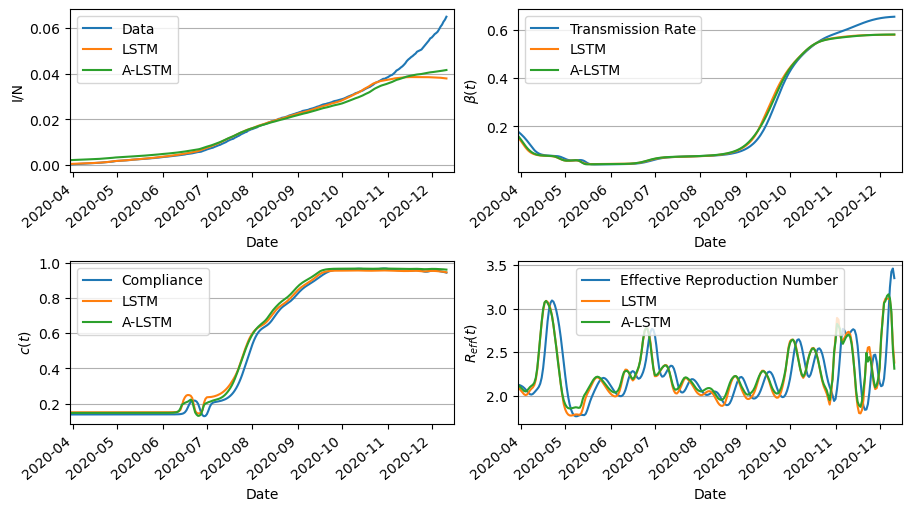

In [12]:
yp1 =np.loadtxt("Figures/ylstm1.txt") #inf
yp2 =np.loadtxt("Figures/ylstm2.txt") #con
yp3 =np.loadtxt("Figures/ylstm3.txt") #tran
yp4 =np.loadtxt("Figures/ylstm4.txt") #r_eff

yp1a =np.loadtxt("Figures/yalstm1.txt") #inf
yp2a=np.loadtxt("Figures/yalstm2.txt")  #con
yp3a =np.loadtxt("Figures/yalstm3.txt") #con
yp4a =np.loadtxt("Figures/yalstm4.txt") #r_eff


date_begin = dt.date(2020, 3, 30)
date_end = date_begin + dt.timedelta(days=257)
delt = dt.timedelta(days=1)
dates = mpl.dates.drange(date_begin, date_end, delt)
lims = (np.datetime64(st), np.datetime64(ed))

fig1A7, ax1 = plt.subplots(2, 2,constrained_layout=True,figsize=(9, 5))
ax1[0,0].plot(dates, inf[:-4,:], label='Data')
ax1[0,0].plot(dates, yp1, label='LSTM')
ax1[0,0].plot(dates, yp1a, label='A-LSTM')
ax1[0,0].set_xlabel('Date')
ax1[0,0].set_ylabel('I/N')
ax1[0,0].set_xlim(lims)
# ax1[0].set_ylim([-0.1,0.5])
for label in ax1[0,0].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[0,0].legend()
ax1[0,0].grid(axis='y')

ax1[1,0].plot(dates, com[:-4], label='Compliance')
ax1[1,0].plot(dates, yp2, label='LSTM')
ax1[1,0].plot(dates, yp2a, label='A-LSTM')
ax1[1,0].set_xlabel('Date')
ax1[1,0].set_ylabel(r'$c(t)$')
ax1[1,0].set_xlim(lims)
# ax1[0].set_ylim([-0.1,0.5])
for label in ax1[1,0].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[1,0].legend()
ax1[1,0].grid(axis='y')

ax1[0,1].plot(dates, tran[:-4], label='Transmission Rate')
ax1[0,1].plot(dates, yp3, label='LSTM')
ax1[0,1].plot(dates, yp3a, label='A-LSTM')
ax1[0,1].set_xlabel('Date')
ax1[0,1].set_ylabel(r'$\beta(t)$')
ax1[0,1].set_xlim(lims)
# ax1[0].set_ylim([-0.1,0.5])
for label in ax1[0,1].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[0,1].legend()
ax1[0,1].grid(axis='y')

ax1[1,1].plot(dates, reff[:-4], label='Effective Reproduction Number')
ax1[1,1].plot(dates, yp4, label='LSTM')
ax1[1,1].plot(dates, yp4a, label='A-LSTM')
ax1[1,1].set_xlabel('Date')
ax1[1,1].set_ylabel(r'$R_{eff}(t)$')
ax1[1,1].set_xlim(lims)
# ax1[0].set_ylim([-0.1,0.5])
for label in ax1[1,1].get_xticklabels():
    label.set_rotation(40)
    label.set_horizontalalignment('right')
ax1[1,1].legend()
ax1[1,1].grid(axis='y')

fig1A7.savefig(out+"lstmalst.pdf")
plt.show()


## Sensitvity Analysis

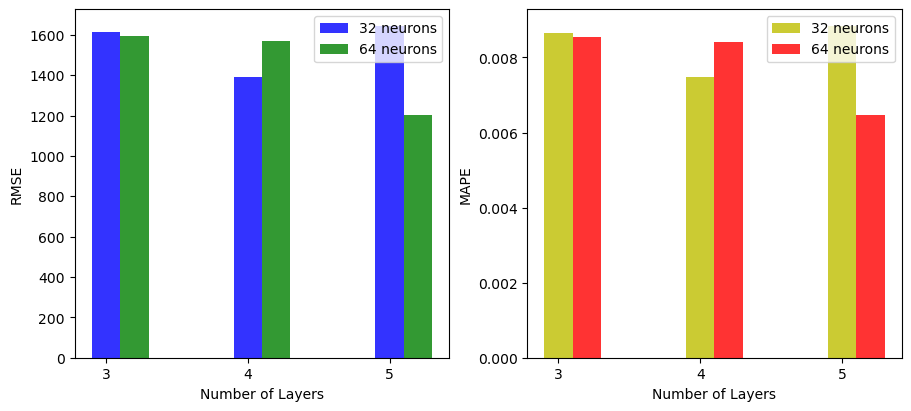

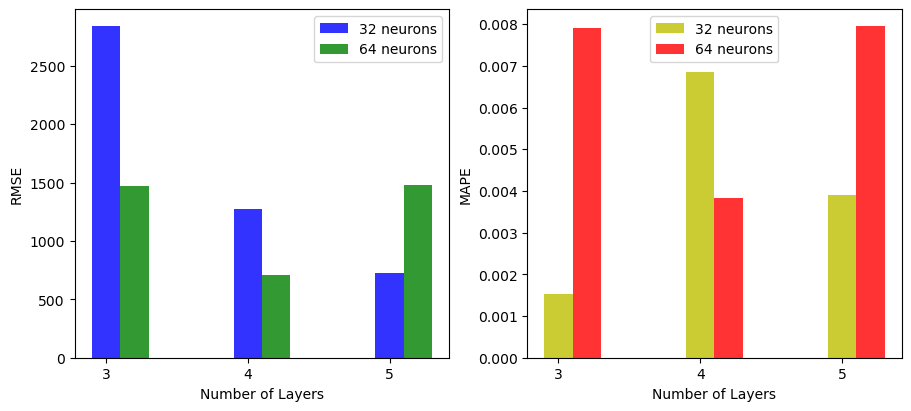

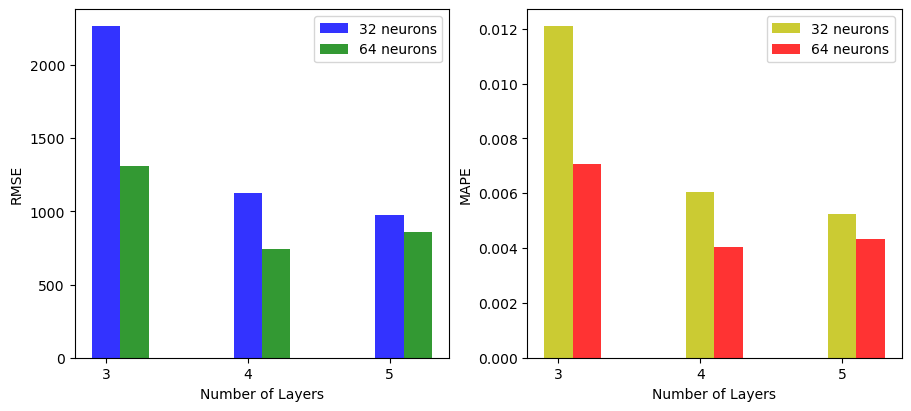

In [13]:
layers = ['3', '4', '5']
neurons = ['32', '64']

# Input data
rmse_3 = [2842, 1612, 2268]
rmse_3_64 = [1473, 1592, 1313]

rmse_4 = [1277, 1393, 1128]
rmse_4_64 =[712, 1567,740]

rmse_5 = [726, 1644, 977]
rmse_5_64 = [1482, 1201, 862]

#Input data
mape_3 =[8.66e-3, 1.53e-3, 1.21e-2]
mape_3_64 =[8.55e-3, 7.92e-3, 7.05e-3]

mape_4 =[7.48e-3, 6.86e-3, 6.06e-3]
mape_4_64 =[8.42e-3, 3.83e-3, 4.03e-3]

mape_5 =[8.84e-3, 3.90e-3, 5.25e-3]
mape_5_64 =[6.46e-3, 7.96e-3, 4.33e-3]


# Set bar width
bar_width = 0.2

# Create the figure and axes objects
fig1A8, ax1 = plt.subplots(1, 2,constrained_layout=True,figsize=(9, 4))
# Set the x-axis tick locations and labels
ax1[0].set_xticks(np.arange(len(layers)))
ax1[0].set_xticklabels(layers)
# Set the y-axis label
ax1[0].set_ylabel('RMSE')
ax1[0].set_xlabel('Number of Layers')
# Set the chart title
# ax1.set_title('Comparison of RMSE values for different layers and neurons')
# Set the opacity of the bars
opacity = 0.8
# Plot the paired RMSE values
rects1 = ax1[0].bar(np.arange(len(layers)), [rmse_3[1], rmse_4[1], rmse_5[1]], bar_width, alpha=opacity, color='b', label='32 neurons')
rects2 = ax1[0].bar(np.arange(len(layers)) + bar_width, [rmse_3_64[1], rmse_4_64[1], rmse_5_64[1]], bar_width, alpha=opacity, color='g', label='64 neurons')
ax1[0].legend()


# Set the x-axis tick locations and labels
ax1[1].set_xticks(np.arange(len(layers)))
ax1[1].set_xticklabels(layers)
# Set the y-axis label
ax1[1].set_ylabel('MAPE')
ax1[1].set_xlabel('Number of Layers')
# Set the chart title
# ax1.set_title('Comparison of RMSE values for different layers and neurons')
# Set the opacity of the bars
opacity = 0.8
# Plot the paired RMSE values
rects1 = ax1[1].bar(np.arange(len(layers)), [mape_3[0], mape_4[0], mape_5[0]], bar_width, alpha=opacity, color='y', label='32 neurons')
rects2 = ax1[1].bar(np.arange(len(layers)) + bar_width, [mape_3_64[0], mape_4_64[0], mape_5_64[0]], bar_width, alpha=opacity, color='r', label='64 neurons')
ax1[1].legend()
fig1A8.savefig(out+'epsilon01.pdf')
plt.show()



# Create the figure and axes objects
fig1A9, ax1 = plt.subplots(1, 2,constrained_layout=True,figsize=(9, 4))
# Set the x-axis tick locations and labels
ax1[0].set_xticks(np.arange(len(layers)))
ax1[0].set_xticklabels(layers)
# Set the y-axis label
ax1[0].set_ylabel('RMSE')
ax1[0].set_xlabel('Number of Layers')
# Set the chart title
# ax1.set_title('Comparison of RMSE values for different layers and neurons')
# Set the opacity of the bars
opacity = 0.8
# Plot the paired RMSE values
rects1 = ax1[0].bar(np.arange(len(layers)), [rmse_3[0], rmse_4[0], rmse_5[0]], bar_width, alpha=opacity, color='b', label='32 neurons')
rects2 = ax1[0].bar(np.arange(len(layers)) + bar_width, [rmse_3_64[0], rmse_4_64[0], rmse_5_64[0]], bar_width, alpha=opacity, color='g', label='64 neurons')
ax1[0].legend()


# Set the x-axis tick locations and labels
ax1[1].set_xticks(np.arange(len(layers)))
ax1[1].set_xticklabels(layers)
# Set the y-axis label
ax1[1].set_ylabel('MAPE')
ax1[1].set_xlabel('Number of Layers')
# Set the chart title
# ax1.set_title('Comparison of RMSE values for different layers and neurons')
# Set the opacity of the bars
opacity = 0.8
# Plot the paired RMSE values
rects1 = ax1[1].bar(np.arange(len(layers)), [mape_3[1], mape_4[1], mape_5[1]], bar_width, alpha=opacity, color='y', label='32 neurons')
rects2 = ax1[1].bar(np.arange(len(layers)) + bar_width, [mape_3_64[1], mape_4_64[1], mape_5_64[1]], bar_width, alpha=opacity, color='r', label='64 neurons')
ax1[1].legend()
fig1A9.savefig(out+'epsilon02.pdf')
plt.show()



# Create the figure and axes objects
fig1A10, ax1 = plt.subplots(1, 2,constrained_layout=True,figsize=(9, 4))
# Set the x-axis tick locations and labels
ax1[0].set_xticks(np.arange(len(layers)))
ax1[0].set_xticklabels(layers)
# Set the y-axis label
ax1[0].set_ylabel('RMSE')
ax1[0].set_xlabel('Number of Layers')
# Set the chart title
# ax1.set_title('Comparison of RMSE values for different layers and neurons')
# Set the opacity of the bars
opacity = 0.8
# Plot the paired RMSE values
rects1 = ax1[0].bar(np.arange(len(layers)), [rmse_3[2], rmse_4[2], rmse_5[2]], bar_width, alpha=opacity, color='b', label='32 neurons')
rects2 = ax1[0].bar(np.arange(len(layers)) + bar_width, [rmse_3_64[2], rmse_4_64[2], rmse_5_64[2]], bar_width, alpha=opacity, color='g', label='64 neurons')
ax1[0].legend()


# Set the x-axis tick locations and labels
ax1[1].set_xticks(np.arange(len(layers)))
ax1[1].set_xticklabels(layers)
# Set the y-axis label
ax1[1].set_ylabel('MAPE')
ax1[1].set_xlabel('Number of Layers')
# Set the chart title
# ax1.set_title('Comparison of RMSE values for different layers and neurons')
# Set the opacity of the bars
opacity = 0.8
# Plot the paired RMSE values
rects1 = ax1[1].bar(np.arange(len(layers)), [mape_3[2], mape_4[2], mape_5[2]], bar_width, alpha=opacity, color='y', label='32 neurons')
rects2 = ax1[1].bar(np.arange(len(layers)) + bar_width, [mape_3_64[2], mape_4_64[2], mape_5_64[2]], bar_width, alpha=opacity, color='r', label='64 neurons')
ax1[1].legend()
fig1A10.savefig(out+'epsilon03.pdf')
plt.show()


## Overfitting Analysis

`Analysis for epochs 40000 and 100000`

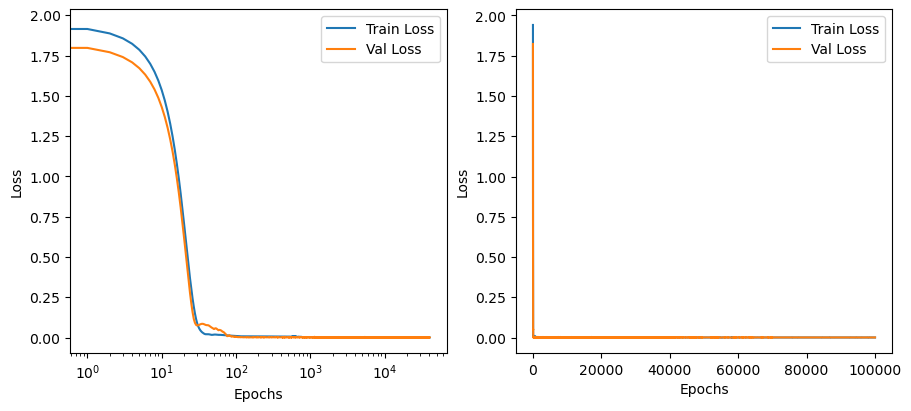

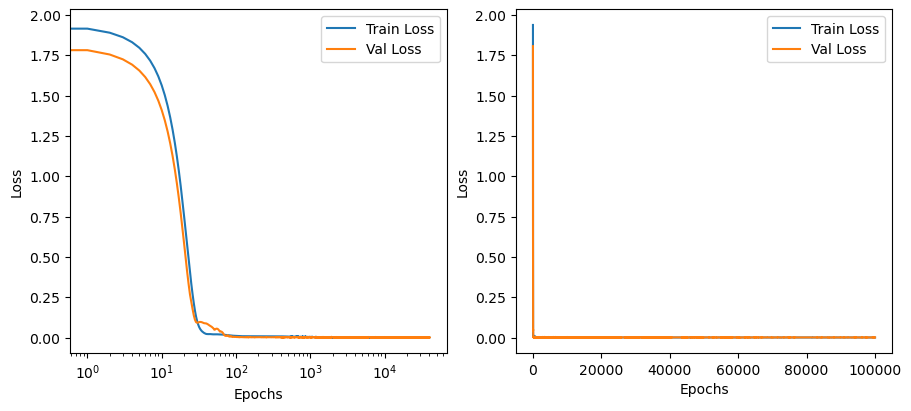

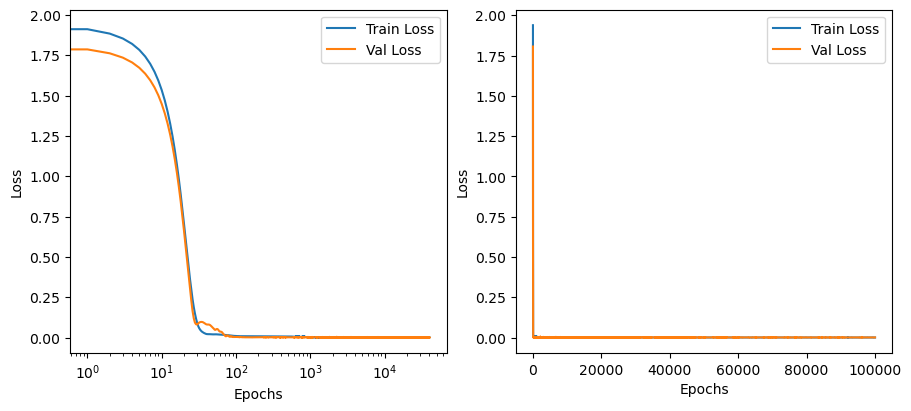

In [14]:
loss_train43 =np.loadtxt("Figures/loss_train_40000_1e-07.txt")
loss_val43 =np.loadtxt("Figures/loss_val_40000_1e-07.txt")

loss_train42 =np.loadtxt("Figures/loss_train_40000_0.001.txt")
loss_val42 =np.loadtxt("Figures/loss_val_40000_0.001.txt")

loss_train41 =np.loadtxt("Figures/loss_train_40000_0.1.txt")
loss_val41 =np.loadtxt("Figures/loss_val_40000_0.1.txt")



loss_train_3 =np.loadtxt("Figures/loss_train_100000_1e-07.txt")
loss_val_3 =np.loadtxt("Figures/loss_val_100000_1e-07.txt")

loss_train_2 =np.loadtxt("Figures/loss_train_100000_0.001.txt")
loss_val_2 =np.loadtxt("Figures/loss_val_100000_0.001.txt")

loss_train_1 =np.loadtxt("Figures/loss_train_100000_0.1.txt")
loss_val_1 =np.loadtxt("Figures/loss_val_100000_0.1.txt")

e1 =60000
e2 =100000
e3 =40000
e5 =50000


fig2AA, ax1 = plt.subplots(1, 2,constrained_layout=True,figsize=(9, 4))
epochs =np.arange(e3)
ax1[0].semilogx(epochs, loss_train41, label='Train Loss')
ax1[0].semilogx(epochs, loss_val41, label='Val Loss')
ax1[0].set_xlabel('Epochs')
ax1[0].set_ylabel('Loss')
ax1[0].legend()

epochs =np.arange(e2)
ax1[1].plot(epochs, loss_train_1, label='Train Loss')
ax1[1].plot(epochs, loss_val_1, label='Val Loss')
ax1[1].set_xlabel('Epochs')
ax1[1].set_ylabel('Loss')
ax1[1].legend()
fig2AA.savefig(out+"overfit01.pdf".format())
plt.show()


fig2AB, ax1 = plt.subplots(1, 2,constrained_layout=True,figsize=(9, 4))
epochs =np.arange(e3)
ax1[0].semilogx(epochs, loss_train42, label='Train Loss')
ax1[0].semilogx(epochs, loss_val42, label='Val Loss')
ax1[0].set_xlabel('Epochs')
ax1[0].set_ylabel('Loss')
ax1[0].legend()

epochs =np.arange(e2)
ax1[1].plot(epochs, loss_train_2, label='Train Loss')
ax1[1].plot(epochs, loss_val_2, label='Val Loss')
ax1[1].set_xlabel('Epochs')
ax1[1].set_ylabel('Loss')
ax1[1].legend()
fig2AB.savefig(out+"overfit02.pdf".format())
plt.show()


fig2AC, ax1 = plt.subplots(1, 2,constrained_layout=True,figsize=(9, 4))
epochs =np.arange(e3)
ax1[0].semilogx(epochs, loss_train43, label='Train Loss')
ax1[0].semilogx(epochs, loss_val43, label='Val Loss')
ax1[0].set_xlabel('Epochs')
ax1[0].set_ylabel('Loss')
ax1[0].legend()

epochs =np.arange(e2)
ax1[1].plot(epochs, loss_train_3, label='Train Loss')
ax1[1].plot(epochs, loss_val_3, label='Val Loss')
ax1[1].set_xlabel('Epochs')
ax1[1].set_ylabel('Loss')
ax1[1].legend()
fig2AC.savefig(out+"overfit03.pdf".format())
plt.show()

## Computational Analysis

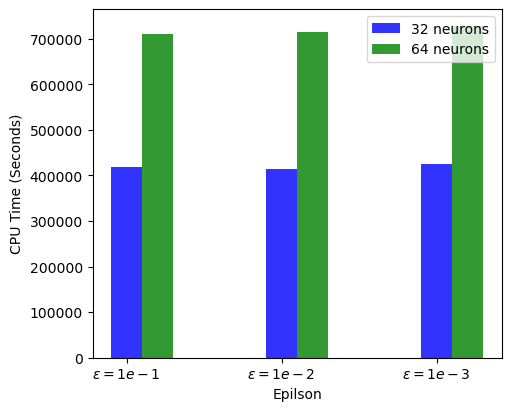

In [15]:
epsilon = [r'$\epsilon=1e-1$', r'$\epsilon=1e-2$', r'$\epsilon=1e-3$']
neurons = ['32', '64']

# Input data
rmse_3 = [2842, 1612, 2268]
rmse_3_64 = [1473, 1592, 1313]

rmse_4 = [1277, 1393, 1128]
rmse_4_64 =[712, 1567,740]

rmse_5 = [726, 1644, 977]
rmse_5_64 = [1482, 1201, 862]

#Input data
mape_3 =[8.66e-3, 1.53e-3, 1.21e-2]
mape_3_64 =[8.55e-3, 7.92e-3, 7.05e-3]

mape_4 =[7.48e-3, 6.86e-3, 6.06e-3]
mape_4_64 =[8.42e-3, 3.83e-3, 4.03e-3]

mape_5 =[8.84e-3, 3.90e-3, 5.25e-3]
mape_5_64 =[6.46e-3, 7.96e-3, 4.33e-3]


# Set bar width
bar_width = 0.2



# Create the figure and axes objects
fig1ABB, ax1 = plt.subplots(constrained_layout=True,figsize=(5, 4))
# Set the x-axis tick locations and labels
ax1.set_xticks(np.arange(len(epsilon)))
ax1.set_xticklabels(epsilon)
# Set the y-axis label
ax1.set_ylabel('CPU Time (Seconds)')
ax1.set_xlabel('Epilson')
# Set the chart title
# ax1.set_title('Comparison of RMSE values for different layers and neurons')
# Set the opacity of the bars
opacity = 0.8
# Plot the paired RMSE values
rects1 = ax1.bar(np.arange(len(epsilon)), [419117, 413836, 424608], bar_width, alpha=opacity, color='b', label='32 neurons')
rects2 = ax1.bar(np.arange(len(epsilon)) + bar_width, [711102, 714602, 728276], bar_width, alpha=opacity, color='g', label='64 neurons')
ax1.legend()
fig1ABB.savefig(out+'eps_cputime.pdf')
plt.show()




In [21]:
import numpy as np
import pandas as pd
import os
import datetime
# from pyDOE import lhs
import sys
sys.path.insert(0, '../../Utilities/')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import torch
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
import torch.autograd as autograd
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import CubicSpline
from collections import OrderedDict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import explained_variance_score
import timeit
from tqdm import tqdm
#Set default dtype to float32
torch.set_default_dtype(torch.float)
torch.manual_seed(1234)
np.random.seed(1234)

##Output Folders
c_dir =os.getcwd()
path = '/FIGURES/'
out = c_dir +path
if not os.path.exists(out):
    os.makedirs(out)


# # Define your base PINN model
# class BasePINN(nn.Module):
#     def __init__(self, input_dim, l_b, u_b):
#         super(BasePINN, self).__init__()
#         self.l_b = l_b
#         self.u_b = u_b
#         self.attention = nn.MultiheadAttention(1, num_heads=1)
#         self.fc1 = nn.Linear(input_dim, 64)
#         self.fc2 = nn.Linear(64, 64)
#         self.fc3 = nn.Linear(64, 64)
#         self.fc4 = nn.Linear(64, 64)
#         self.fc5 = nn.Linear(64, 1)

#     def forward(self, t):
#         if torch.is_tensor(t) != True:
#             t = torch.from_numpy(t)
#         l_b = torch.tensor(self.l_b).float()
#         u_b = torch.tensor(self.u_b).float()
#         t = 2 * ((t - l_b) / (u_b - l_b)) - 1.0
#         x = t.float()
#         x = x.unsqueeze(0)  # Add an extra dimension at the beginning
#         x = x.permute(2, 0, 1)  # Reshape to (seq_len, batch_size, input_dim)
#         x = self.attention(x, x, x)[0]  # Apply attention mechanism
#         x = torch.tanh(self.fc1(x.squeeze(dim=0)))  # Remove the middle dimension
#         x = torch.tanh(self.fc2(x))
#         x = torch.tanh(self.fc3(x))
#         x = torch.tanh(self.fc4(x))
#         x = self.fc5(x)
#         return x.squeeze()  # Remove the extra dimensions

# class AttentionPINN(nn.Module):
#     def __init__(self, input_dim, l_b, u_b, hidden_dim, output_dim, num_layers, dropout=0.1):
#         super().__init__()
#         self.l_b = l_b
#         self.u_b = u_b

#         self.input_dim = input_dim
#         self.hidden_dim = hidden_dim
#         self.output_dim = output_dim
#         self.num_layers = num_layers
#         self.dropout = dropout

#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.Tanh(),
#             nn.Dropout(dropout),
#             *[nn.Linear(hidden_dim, hidden_dim) for _ in range(num_layers - 1)],
#             nn.Tanh(),
#             nn.Dropout(dropout),
#         )

#         self.attention = nn.MultiheadAttention(hidden_dim, num_heads=8)

#         self.decoder = nn.Sequential(
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.Tanh(),
#             nn.Dropout(dropout),
#             nn.Linear(hidden_dim, output_dim),
#         )

#     def forward(self, t):
#         if torch.is_tensor(t) != True:
#             t = torch.from_numpy(t)
#         l_b = torch.tensor(self.l_b).float()
#         u_b = torch.tensor(self.u_b).float()
#         t = 2 * ((t - l_b) / (u_b - l_b)) - 1.0
#         x = t.float()
#         x = x.unsqueeze(0)
#         x = self.encoder(x)
#         x = x.view(1, x.shape[0], x.shape[1])
#         x = self.attention(x, x, x)
#         x = self.decoder(x)
#         return x


# Define the attention mechanism
# Define the attention mechanism
class Attention(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Attention, self).__init__()
        self.W = nn.Linear(input_size, hidden_size)
        self.V = nn.Linear(hidden_size, 1)

    def forward(self, inputs):
        hidden = torch.tanh(self.W(inputs))
        scores = self.V(hidden)
        weights = torch.softmax(scores, dim=1)
        context = torch.sum(weights * inputs, dim=1)
        return context

# Define the attention-based PINN model
class AttentionPINN(nn.Module):
    def __init__(self, input_size, l_b, u_b, hidden_size):
        super(AttentionPINN, self).__init__()
        self.l_b =l_b
        self.u_b =u_b
        self.attention = Attention(input_size, hidden_size)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, inputs):
        t =inputs
        if torch.is_tensor(t) != True:
            t = torch.from_numpy(t)
        l_b = torch.tensor(self.l_b).float()
        u_b = torch.tensor(self.u_b).float()
        t = 2 * ((t - l_b) / (u_b - l_b)) - 1.0
        x = t.float()
        context = self.attention(x)
        hidden = torch.relu(self.fc1(context))
        output = self.fc2(hidden)
        return output

    
    
    
    
    
def loss_function(PINNs, y_true, eps, t):
    t.requires_grad=True
    S_true = y_true[:, 0:1]
    I_true = y_true[:, 1:2]
    R_true = y_true[:, 2:3]
    D_true = y_true[:, 3:4]
    S, I, R, D, beta, gamma, delta, compliance = [pinn(t) for pinn in PINNs]
    # Calculate the derivative of each compartment with respect to time
    S_t=autograd.grad(S,t,torch.ones_like(S),
                        retain_graph=True, create_graph=True)[0]
    I_t=autograd.grad(I,t,torch.ones_like(I),
                        retain_graph=True, create_graph=True)[0]
    R_t=autograd.grad(R,t,torch.ones_like(R),
                        retain_graph=True, create_graph=True)[0]
    D_t=autograd.grad(D,t,torch.ones_like(D),
                        retain_graph=True, create_graph=True)[0]

    e1 = S_t + beta * (1.0 - compliance) * S * I
    e2 = I_t - beta * (1.0 - compliance) * S * I + gamma * I + delta * I
    e3 = R_t - gamma * I
    e4 = D_t - delta * I
    e5 = 1.0 - (S + I + R + D)

    # Get the residual loss
    lossPhy = torch.mean(torch.abs(e1)) + torch.mean(torch.abs(e2)) + \
              torch.mean(torch.abs(e3)) + torch.mean(torch.abs(e4)) + \
              torch.mean(torch.abs(e5))
    S_loss =torch.mean(torch.abs(S_true - S))
    I_loss =torch.mean(torch.abs(I_true - I))
    R_loss =torch.mean(torch.abs(R_true - R))
    D_loss =torch.mean(torch.abs(D_true - D))

    # # Get the data loss
    # S_loss = 0
    # I_loss = 0
    # R_loss = 0
    # D_loss = 0
    # iter = 0
    # for i in range(len(t)):
    #     if t[i] % 1 == 0 and iter < len(S_true):
    #         S_loss += torch.abs(S_true[iter] - S[i])
    #         I_loss += torch.abs(I_true[iter] - I[i])
    #         R_loss += torch.abs(R_true[iter] - R[i])
    #         D_loss += torch.abs(D_true[iter] - D[i])
    #         iter += 1
    lossData = (I_loss + R_loss + S_loss + D_loss) 
    overall_loss = (1 - eps) * lossData + eps * lossPhy
    return overall_loss, lossPhy, lossData

def train_PINNs(PINNs, data, epochs,eps,t, optimizer):
    t.requires_grad=True
    for epoch in range(epochs):
        total_loss, lossPhy, lossData= loss_function(PINNs, data, eps, t)
        optimizer.zero_grad()
        total_loss.backward()
        # lossPhy.backward(retain_graph=True)
        # lossData.backward(retain_graph=True)
        optimizer.step()
        #scheduler.step()
        if epoch % 1000== 0:
            print(f"Epoch: {epoch}, Total Loss: {total_loss.item()}")
    return



data =pd.read_csv("tndata.csv")
def data_preprocess(data, lb, ub, N0, npoints,cs ="yes"):
    tdat=data.reindex(index=data.index[::-1])
    ic = tdat["TOTAL_CASES"]
    dc = tdat["TOTAL_DEATHS"]
    re = tdat["TOTAL_INACTIVE_RECOVERED"]
    y1, y2 =np.array(ic.values), np.array(dc.values)
    y3   =np.array(re.values)
    y4 =y1-y3-y2 #infected cases
    I, R, D =y1[lb:ub],y3[lb:ub], y2[lb:ub]
    S =N0-I-R-D
    length =int(ub-lb)
    T = np.arange(0,length).reshape(length,1)
    dd =np.arange(length)
    if cs =="yes":
        s1 =CubicSpline(dd,S)
        s2 =CubicSpline(dd,I)
        s3 =CubicSpline(dd,R)
        s4 =CubicSpline(dd,D)
        tt=np.linspace(0,length, npoints)
        x, yy1, yy2, yy3, yy4 =tt, s1(tt), s2(tt), s3(tt), s4(tt)
        TT =x.reshape((-1,1))
        SS =yy1.reshape((-1,1))
        II =yy2.reshape((-1,1))
        RR =yy3.reshape((-1,1))
        DD=yy4.reshape((-1,1))
    else:
        TT=T
        SS =S.reshape((-1,1))
        II =I.reshape((-1,1))
        RR =R.reshape((-1,1))
        DD =D.reshape((-1,1))
    return SS, II, RR, DD, TT

N0 = 6.82*1.e6
lb =19 #change this
ub =280
length=int(ub-lb)
S, I, R, D, T=data_preprocess(data, lb, ub, N0, 3000, "yes")
t=torch.from_numpy(T).float()
SS=torch.from_numpy(S).float()
II=torch.from_numpy(I).float()
RR=torch.from_numpy(R).float()
DD =torch.from_numpy(D).float()
# l_b, u_b =t.min(0), t.max(0)
# PINN_beta = BasePINN(1,l_b, u_b)
# PINN_beta.to(device)
# PINN_gamma = BasePINN(1, l_b, u_b)
# PINN_gamma.to(device)
# PINN_delta = BasePINN(1, l_b, u_b)
# PINN_delta.to(device)
# PINN_compliance = BasePINN(1, l_b, u_b)
# PINN_compliance.to(device)
# PINN_S = BasePINN(1,l_b, u_b)
# PINN_S.to(device)
# PINN_I= BasePINN(1,l_b, u_b)
# PINN_I.to(device)
# PINN_R = BasePINN(1,l_b, u_b)
# PINN_R.to(device)
# PINN_D= BasePINN(1,l_b, u_b)
# PINN_D.to(device)


t = t.to(device)
l_b, u_b =t.min(0), t.max(0)
PINN_beta = AttentionPINN(1,l_b, u_b, 64)
PINN_beta.to(device)
PINN_gamma = AttentionPINN(1,l_b, u_b, 64)
PINN_gamma.to(device)
PINN_delta = AttentionPINN(1,l_b, u_b, 64)
PINN_delta.to(device)
PINN_compliance = AttentionPINN(1,l_b, u_b, 64)
PINN_compliance.to(device)
PINN_S = AttentionPINN(1,l_b, u_b, 64)
PINN_S.to(device)
PINN_I= AttentionPINN(1,l_b, u_b, 64)
PINN_I.to(device)
PINN_R = AttentionPINN(1,l_b, u_b, 64)
PINN_R.to(device)
PINN_D= AttentionPINN(1,l_b, u_b, 64)
PINN_D.to(device) 


PINNs = [PINN_S,PINN_I, PINN_R, PINN_D, PINN_beta, PINN_gamma, PINN_delta, PINN_compliance]
optimizer = optim.Adam(list(PINNs[0].parameters()) + list(PINNs[1].parameters()) + 
                       list(PINNs[2].parameters()) + list(PINNs[3].parameters()) +
                       list(PINNs[4].parameters()) +list(PINNs[5].parameters()) +
                       list(PINNs[6].parameters()) +list(PINNs[7].parameters()), lr=0.001)
epochs =3000
eps =1e-1

y_true =torch.hstack((SS/N0, II/N0, RR/N0, DD/N0)).to(device)


train_PINNs(PINNs, y_true, epochs,eps,t, optimizer)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (3000x2 and 1x64)

In [20]:
t.shape

torch.Size([3000, 1])